# Legal NER - Transformer

This notebook implements a Named Entity Recognition (NER) model for legal texts using a transformer-based approach.

The dataset used can be found here: https://huggingface.co/datasets/elenanereiss/german-ler/tree/main/data

The annotation guidelines the dataset uses can be found here: https://github.com/elenanereiss/Legal-Entity-Recognition/blob/master/docs/Annotationsrichtlinien.pdf

## 1. Install Dependencies

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install transformers datasets pandas pyarrow seqeval accelerate matplotlib seaborn


## 2. Import Libraries

In [ ]:
# =============================================================================
# IMPORT REQUIRED LIBRARIES
# =============================================================================

import pandas as pd                    # Data manipulation and analysis
import numpy as np                     # Numerical operations
import torch                           # Deep learning framework
from datasets import Dataset, DatasetDict  # Hugging Face dataset utilities
from transformers import (
    AutoTokenizer,                     # Loads pre-trained tokenizer
    AutoModelForTokenClassification,   # Loads pre-trained model for token classification
    TrainingArguments,                 # Configuration for training
    Trainer,                           # High-level training API
    DataCollatorForTokenClassification # Handles padding and batching
)
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt        # For visualizations
import seaborn as sns                  # Enhanced visualizations
from collections import Counter        # For counting entities
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CHECK GPU AVAILABILITY
# =============================================================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("\nGPU not detected! Training will be slower on CPU.")
    print("To enable GPU: install PyTorch with CUDA support")


Using device: cuda
GPU Name: NVIDIA GeForce RTX 4070
CUDA Version: 12.1
GPU Memory: 12.88 GB


## 3. Load Data

In [5]:
# Load parquet files
train_df = pd.read_parquet('train-00000-of-00001.parquet')
val_df = pd.read_parquet('validation-00000-of-00001.parquet')
test_df = pd.read_parquet('test-00000-of-00001.parquet')

print(f"Train samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")
print(f"\nColumns: {train_df.columns.tolist()}")
print(f"\nFirst sample:\n{train_df.iloc[0]}")


Train samples: 53384
Validation samples: 6666
Test samples: 6673

Columns: ['tokens', 'ner', 'coarse-ner']

First sample:
tokens        [dd, ), Art., 33, Abs., 5, GG, würde, demnach,...
ner           [O, O, B-GS, I-GS, I-GS, I-GS, I-GS, O, O, O, ...
coarse-ner    [O, O, B-NRM, I-NRM, I-NRM, I-NRM, I-NRM, O, O...
Name: 0, dtype: object


## 4. Explore Data Structure

In [6]:
# Examine data structure
print("Data types:")
print(train_df.dtypes)
print("\nSample data:")
for col in train_df.columns:
    print(f"\n{col}:")
    print(train_df[col].iloc[0])


Data types:
tokens        object
ner           object
coarse-ner    object
dtype: object

Sample data:

tokens:
['dd' ')' 'Art.' '33' 'Abs.' '5' 'GG' 'würde' 'demnach' 'die'
 'Möglichkeit' 'nicht' 'ausschließen' ',' 'unter' 'den' 'vorgenannten'
 'Bedingungen' 'in' 'Ausnahmefällen' 'andere' 'als'
 'Lebenszeitrichterverhältnisse' 'zu' 'begründen' '.']

ner:
['O' 'O' 'B-GS' 'I-GS' 'I-GS' 'I-GS' 'I-GS' 'O' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']

coarse-ner:
['O' 'O' 'B-NRM' 'I-NRM' 'I-NRM' 'I-NRM' 'I-NRM' 'O' 'O' 'O' 'O' 'O' 'O'
 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O' 'O']


## 5. Create Label Mappings

In [ ]:
# =============================================================================
# CONFIGURE COLUMN NAMES - ADJUST THESE BASED ON YOUR DATA!
# =============================================================================
TOKEN_COLUMN = 'tokens'      # Column containing list of words/tokens
LABEL_COLUMN = 'ner'         # Column containing NER labels for each token

# =============================================================================
# EXTRACT ALL UNIQUE LABELS FROM TRAINING DATA
# =============================================================================
# NER uses BIO tagging scheme: B-Entity (beginning), I-Entity (inside), O (outside)
# Example: "Angela Merkel" -> ["B-PER", "I-PER"]
# Example: "Berlin" -> ["B-LOC"]
# Example: "the" -> ["O"]

all_labels = set()
for labels in train_df[LABEL_COLUMN]:
    if isinstance(labels, (list, np.ndarray)):
        all_labels.update(labels)  # Add all labels from this sample
    else:
        all_labels.add(labels)

# Sort labels for consistent ordering across runs
label_list = sorted(list(all_labels), key=lambda x: (str(x), x))
print(f"Found {len(label_list)} unique labels:")
print(label_list)

# =============================================================================
# CREATE BIDIRECTIONAL MAPPINGS
# =============================================================================
# Neural networks work with numbers, not strings. We need to convert:
# - label2id: "B-PER" -> 0, "I-PER" -> 1, "O" -> 2, etc.
# - id2label: 0 -> "B-PER", 1 -> "I-PER", 2 -> "O", etc.

label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

print(f"\nLabel to ID mapping: {label2id}")


Found 39 unique labels:
['B-AN', 'B-EUN', 'B-GRT', 'B-GS', 'B-INN', 'B-LD', 'B-LDS', 'B-LIT', 'B-MRK', 'B-ORG', 'B-PER', 'B-RR', 'B-RS', 'B-ST', 'B-STR', 'B-UN', 'B-VO', 'B-VS', 'B-VT', 'I-AN', 'I-EUN', 'I-GRT', 'I-GS', 'I-INN', 'I-LD', 'I-LDS', 'I-LIT', 'I-MRK', 'I-ORG', 'I-PER', 'I-RR', 'I-RS', 'I-ST', 'I-STR', 'I-UN', 'I-VO', 'I-VS', 'I-VT', 'O']

Label to ID mapping: {'B-AN': 0, 'B-EUN': 1, 'B-GRT': 2, 'B-GS': 3, 'B-INN': 4, 'B-LD': 5, 'B-LDS': 6, 'B-LIT': 7, 'B-MRK': 8, 'B-ORG': 9, 'B-PER': 10, 'B-RR': 11, 'B-RS': 12, 'B-ST': 13, 'B-STR': 14, 'B-UN': 15, 'B-VO': 16, 'B-VS': 17, 'B-VT': 18, 'I-AN': 19, 'I-EUN': 20, 'I-GRT': 21, 'I-GS': 22, 'I-INN': 23, 'I-LD': 24, 'I-LDS': 25, 'I-LIT': 26, 'I-MRK': 27, 'I-ORG': 28, 'I-PER': 29, 'I-RR': 30, 'I-RS': 31, 'I-ST': 32, 'I-STR': 33, 'I-UN': 34, 'I-VO': 35, 'I-VS': 36, 'I-VT': 37, 'O': 38}


## 6. Convert to Hugging Face Dataset

In [ ]:
# =============================================================================
# CONVERT PANDAS DATAFRAMES TO HUGGING FACE DATASETS
# =============================================================================
# Hugging Face Trainer expects data in their Dataset format.
# This function converts our DataFrames and ensures labels are numeric.

def prepare_dataset(df):
    """
    Convert DataFrame to Hugging Face Dataset format.
    
    Args:
        df: pandas DataFrame with tokens and labels
        
    Returns:
        Dataset object ready for tokenization
    """
    data = {
        'tokens': df[TOKEN_COLUMN].tolist(),  # List of token lists
        'ner_tags': []                         # Will hold numeric labels
    }
    
    # Convert string labels to numeric IDs if needed
    for labels in df[LABEL_COLUMN]:
        if isinstance(labels[0], str):
            # Labels are strings like "B-PER" -> convert to IDs
            data['ner_tags'].append([label2id[l] for l in labels])
        else:
            # Labels are already numeric
            data['ner_tags'].append(list(labels))
    
    return Dataset.from_dict(data)

# Create dataset dictionary with train/validation/test splits
dataset = DatasetDict({
    'train': prepare_dataset(train_df),
    'validation': prepare_dataset(val_df),
    'test': prepare_dataset(test_df)
})

print("Dataset structure:")
print(dataset)
print(f"\nExample from training set:")
print(f"Tokens: {dataset['train'][0]['tokens'][:10]}...")
print(f"Labels: {dataset['train'][0]['ner_tags'][:10]}...")


DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 53384
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 6666
    })
    test: Dataset({
        features: ['tokens', 'ner_tags'],
        num_rows: 6673
    })
})


## 7. Load Tokenizer and Model

For German legal texts, I use a German BERT model.

In [ ]:
# =============================================================================
# LOAD PRE-TRAINED GERMAN BERT MODEL
# =============================================================================
# We use transfer learning: start with a model pre-trained on German text,
# then fine-tune it for our specific NER task. This is much better than
# training from scratch.

MODEL_NAME = 'bert-base-german-cased'  # German BERT, preserves uppercase

# Load tokenizer - converts text to token IDs that the model understands
# The tokenizer knows how to split German words, handle umlauts, etc.
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model with a classification head for our number of entity types
# The base BERT layers are pre-trained, only the final classification
# layer needs to learn our specific entity types
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),  # Output size = number of entity types
    id2label=id2label,           # For human-readable predictions
    label2id=label2id            # For converting labels to IDs
)

print(f"Model loaded: {MODEL_NAME}")
print(f"Number of entity types: {len(label_list)}")
print(f"Model parameters: {model.num_parameters():,}")  # ~110M parameters


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: bert-base-german-cased
Number of labels: 39


## 8. Tokenize and Align Labels

In [ ]:
# =============================================================================
# TOKENIZE AND ALIGN LABELS WITH SUBWORD TOKENS
# =============================================================================
# BERT uses subword tokenization: "Bundesverfassungsgericht" might become
# ["Bundes", "##verfassungs", "##gericht"]. We need to assign the same
# NER label to all subword pieces of the same original word.

def tokenize_and_align_labels(examples):
    """
    Tokenize text and align NER labels with subword tokens.
    
    This is crucial because:
    1. BERT splits words into subwords: "playing" -> ["play", "##ing"]
    2. We need each subword to have a label
    3. Special tokens [CLS] and [SEP] get label -100 (ignored in loss)
    
    Args:
        examples: Batch of examples with 'tokens' and 'ner_tags'
        
    Returns:
        Tokenized inputs with aligned labels
    """
    # Tokenize the pre-tokenized words (is_split_into_words=True)
    tokenized_inputs = tokenizer(
        examples['tokens'],
        truncation=True,           # Cut off at max_length
        is_split_into_words=True,  # Input is already word-tokenized
        max_length=512             # BERT's maximum sequence length
    )
    
    labels = []
    for i, label in enumerate(examples['ner_tags']):
        # word_ids maps each subword token to its original word index
        # Example: [None, 0, 1, 1, 2, None] means:
        # - Token 0: [CLS] (None = special token)
        # - Token 1: word 0
        # - Token 2-3: word 1 (split into 2 subwords)
        # - Token 4: word 2
        # - Token 5: [SEP] (None = special token)
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        
        previous_word_idx = None
        label_ids = []
        
        for word_idx in word_ids:
            if word_idx is None:
                # Special tokens ([CLS], [SEP], [PAD]) get -100
                # PyTorch ignores -100 in loss calculation
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # First subword of a new word - use the word's label
                label_ids.append(label[word_idx])
            else:
                # Continuation of same word (##piece)
                # Use same label as the first subword
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        
        labels.append(label_ids)
    
    tokenized_inputs['labels'] = labels
    return tokenized_inputs

# Apply tokenization to all splits
print("Tokenizing datasets...")
tokenized_dataset = dataset.map(
    tokenize_and_align_labels,
    batched=True,                              # Process in batches for speed
    remove_columns=dataset['train'].column_names  # Remove old columns
)

print("Tokenization complete!")
print(tokenized_dataset)
print(f"\nExample tokenized input:")
print(f"Input IDs: {tokenized_dataset['train'][0]['input_ids'][:15]}...")
print(f"Labels: {tokenized_dataset['train'][0]['labels'][:15]}...")


Map: 100%|██████████| 6673/6673 [00:00<00:00, 12367.41 examples/s]

Tokenization complete!
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 53384
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 6666
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 6673
    })
})


## 9. Define Metrics

In [ ]:
# =============================================================================
# DEFINE EVALUATION METRICS
# =============================================================================
# For NER, we use seqeval metrics which understand BIO tagging:
# - Precision: Of all entities we predicted, how many were correct?
# - Recall: Of all actual entities, how many did we find?
# - F1: Harmonic mean of precision and recall (balances both)

def compute_metrics(eval_preds):
    """
    Compute precision, recall, and F1 score for NER.
    
    Args:
        eval_preds: Tuple of (predictions, labels) from the model
        
    Returns:
        Dictionary with precision, recall, and F1 scores
    """
    predictions, labels = eval_preds
    # predictions shape: (num_samples, seq_length, num_labels)
    # Get the most likely label for each token
    predictions = np.argmax(predictions, axis=2)
    
    # Convert numeric predictions back to label strings
    # Skip tokens with label -100 (special tokens)
    true_predictions = [
        [id2label[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [id2label[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    # Convert to strings for seqeval
    true_predictions = [[str(p) for p in preds] for preds in true_predictions]
    true_labels = [[str(l) for l in labs] for labs in true_labels]
    
    # Calculate metrics
    results = {
        'precision': precision_score(true_labels, true_predictions),
        'recall': recall_score(true_labels, true_predictions),
        'f1': f1_score(true_labels, true_predictions),
    }
    return results


## 10. Training Configuration

In [ ]:
# =============================================================================
# CONFIGURE TRAINING HYPERPARAMETERS
# =============================================================================
# These settings control how the model learns. Key parameters:
# - learning_rate: How big steps to take when updating weights (2e-5 is standard for BERT)
# - batch_size: How many samples to process at once (limited by GPU memory)
# - num_train_epochs: How many times to go through the entire training data
# - weight_decay: Regularization to prevent overfitting

training_args = TrainingArguments(
    output_dir='./ner_model',               # Where to save checkpoints
    eval_strategy='epoch',                  # Evaluate after each epoch
    save_strategy='epoch',                  # Save model after each epoch
    learning_rate=2e-5,                     # Learning rate (2e-5 is standard for BERT)
    per_device_train_batch_size=16,         # Batch size for training
    per_device_eval_batch_size=16,          # Batch size for evaluation
    num_train_epochs=3,                     # Number of training epochs
    weight_decay=0.01,                      # L2 regularization
    logging_dir='./logs',                   # TensorBoard logs
    logging_steps=100,                      # Log every N steps
    load_best_model_at_end=True,            # Load best model when done
    metric_for_best_model='f1',             # Use F1 to determine best model
    push_to_hub=False,                      # Don't upload to Hugging Face Hub
    report_to='none'                        # Disable external logging
)

# Data collator handles dynamic padding - pads sequences in each batch
# to the same length (more efficient than padding everything to max_length)
data_collator = DataCollatorForTokenClassification(tokenizer)

# Create Trainer - high-level API that handles the training loop
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

print("Trainer configured!")
print(f"Training samples: {len(tokenized_dataset['train'])}")
print(f"Validation samples: {len(tokenized_dataset['validation'])}")
print(f"Epochs: {training_args.num_train_epochs}")
print(f"Batch size: {training_args.per_device_train_batch_size}")
print(f"Learning rate: {training_args.learning_rate}")


Trainer configured!


## 11. Train the Model

In [15]:
# Train the model
print("Starting training...")
trainer.train()


Starting training...


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,0.009900,0.030203,0.918590,0.941896,0.930097
2,0.009300,0.027696,0.936080,0.952938,0.944434
3,0.001300,0.026907,0.945886,0.958196,0.952002


TrainOutput(global_step=10011, training_loss=0.007951323713446019, metrics={'train_runtime': 1174.3143, 'train_samples_per_second': 136.379, 'train_steps_per_second': 8.525, 'total_flos': 9992708434921824.0, 'train_loss': 0.007951323713446019, 'epoch': 3.0})

## 12. Evaluate on Test Set

In [16]:
# Evaluate on test set
print("Evaluating on test set...")
test_results = trainer.evaluate(tokenized_dataset['test'])
print(f"\nTest Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")


Evaluating on test set...



Test Results:
eval_loss: 0.0110
eval_precision: 0.9671
eval_recall: 0.9769
eval_f1: 0.9720
eval_runtime: 15.6125
eval_samples_per_second: 427.4130
eval_steps_per_second: 26.7730
epoch: 3.0000


## 13. Detailed Classification Report

In [ ]:
# =============================================================================
# GET PREDICTIONS FOR DETAILED ANALYSIS
# =============================================================================
# Run the model on the test set to get all predictions

predictions, labels, _ = trainer.predict(tokenized_dataset['test'])
predictions = np.argmax(predictions, axis=2)

# Convert numeric IDs back to label strings (skip special tokens with -100)
true_predictions = [
    [str(id2label[p]) for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [str(id2label[l]) for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]

print("Classification Report:")
print("=" * 60)
print(classification_report(true_labels, true_predictions))
print("=" * 60)
print("\nInterpretation:")
print("- Precision: Of predicted entities, how many were correct?")
print("- Recall: Of actual entities, how many did we find?")
print("- F1-score: Balance between precision and recall")
print("- Support: Number of actual occurrences in test set")


Classification Report:
              precision    recall  f1-score   support

          AN       1.00      0.92      0.96        13
         EUN       0.96      0.99      0.97       282
         GRT       0.99      0.99      0.99       517
          GS       0.98      0.99      0.99      2299
         INN       0.95      0.98      0.96       408
          LD       0.99      0.84      0.91       206
         LDS       0.55      1.00      0.71        34
         LIT       0.96      0.99      0.97       766
         MRK       0.99      1.00      0.99        87
         ORG       0.93      0.93      0.93       230
         PER       0.95      0.94      0.95       293
          RR       0.99      1.00      0.99       314
          RS       0.99      0.99      0.99      1539
          ST       0.91      0.91      0.91       108
         STR       0.80      0.92      0.85        38
          UN       0.99      0.97      0.98       237
          VO       0.83      0.80      0.82       116
    

## 14. Visualize Model Performance

Graphical analysis of errors: missed entities (False Negatives) and false predictions (False Positives).

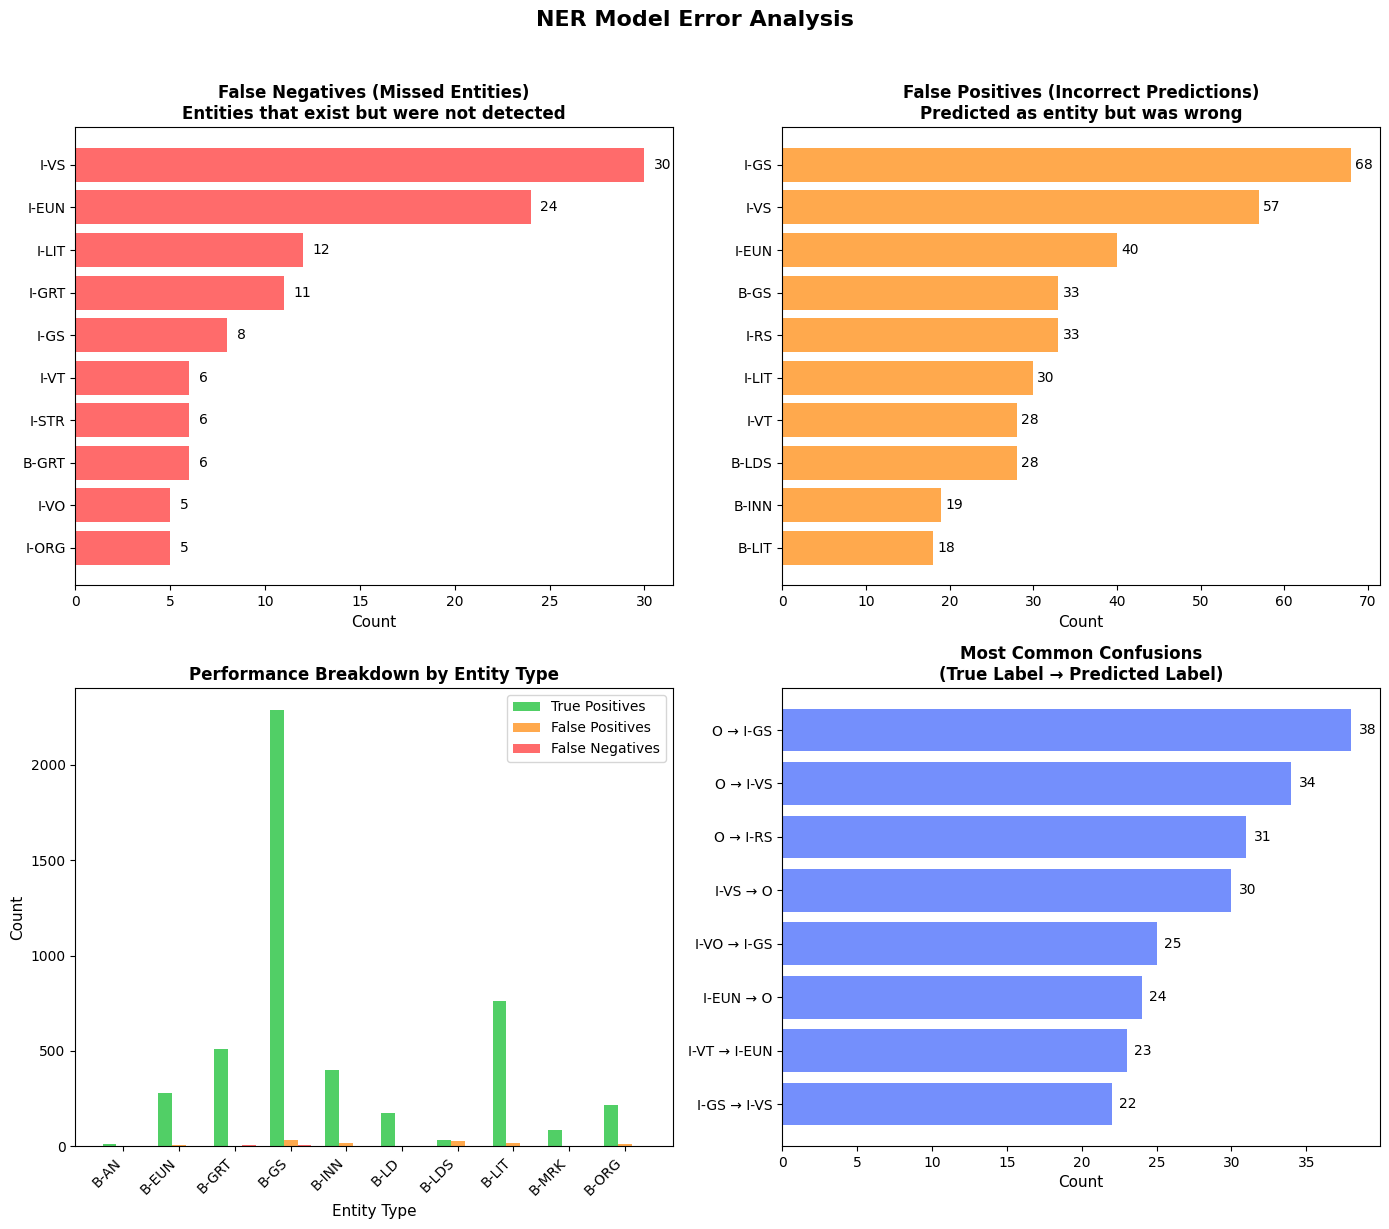


ERROR ANALYSIS SUMMARY

Total True Positives (correct predictions): 57240
Total False Positives (wrong predictions): 482
Total False Negatives (missed entities): 158

Overall Precision: 99.16%
Overall Recall: 99.72%

Top 5 Most Missed Entity Types (False Negatives):
  - I-VS: 30 missed
  - I-EUN: 24 missed
  - I-LIT: 12 missed
  - I-GRT: 11 missed
  - I-GS: 8 missed

Top 5 Most Over-predicted Entity Types (False Positives):
  - I-GS: 68 incorrect predictions
  - I-VS: 57 incorrect predictions
  - I-EUN: 40 incorrect predictions
  - B-GS: 33 incorrect predictions
  - I-RS: 33 incorrect predictions


In [21]:
# =============================================================================
# VISUALIZE NER PERFORMANCE - FALSE POSITIVES AND FALSE NEGATIVES
# =============================================================================
# This section creates charts showing:
# 1. Confusion matrix for entity types
# 2. False Positives (predicted entity but was wrong)
# 3. False Negatives (missed entities)
# 4. Per-entity performance comparison

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# -----------------------------------------------------------------------------
# 1. Count errors by entity type
# -----------------------------------------------------------------------------
false_positives = Counter()  # Predicted entity, but actually O or different entity
false_negatives = Counter()  # Actual entity, but predicted as O or different
true_positives = Counter()   # Correctly predicted entities
confusion_pairs = Counter()  # (true_label, pred_label) pairs

# Flatten all predictions and labels for analysis
all_true = []
all_pred = []
for true_seq, pred_seq in zip(true_labels, true_predictions):
    all_true.extend(true_seq)
    all_pred.extend(pred_seq)

# Analyze each prediction
for true_label, pred_label in zip(all_true, all_pred):
    # Track confusion pairs (excluding O->O as it's not interesting)
    if true_label != pred_label:
        confusion_pairs[(true_label, pred_label)] += 1
    
    # Skip "O" (non-entity) for FP/FN analysis - focus on actual entities
    true_is_entity = not str(true_label).startswith('O') and str(true_label) != 'O'
    pred_is_entity = not str(pred_label).startswith('O') and str(pred_label) != 'O'
    
    if true_is_entity and pred_is_entity and true_label == pred_label:
        # True Positive: correctly identified entity
        true_positives[true_label] += 1
    elif pred_is_entity and (not true_is_entity or true_label != pred_label):
        # False Positive: predicted entity that doesn't exist or is wrong type
        false_positives[pred_label] += 1
    elif true_is_entity and (not pred_is_entity or true_label != pred_label):
        # False Negative: missed an actual entity
        false_negatives[true_label] += 1

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# -----------------------------------------------------------------------------
# Plot 1: False Negatives by Entity Type (Missed Entities)
# -----------------------------------------------------------------------------
ax1 = axes[0, 0]
if false_negatives:
    fn_labels = [label for label, _ in false_negatives.most_common(10)]
    fn_counts = [count for _, count in false_negatives.most_common(10)]
    bars1 = ax1.barh(fn_labels, fn_counts, color='#FF6B6B')
    ax1.set_xlabel('Count', fontsize=11)
    ax1.set_title('False Negatives (Missed Entities)\nEntities that exist but were not detected', 
                  fontsize=12, fontweight='bold')
    # Add count labels on bars
    for bar, count in zip(bars1, fn_counts):
        ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                str(count), va='center', fontsize=10)
else:
    ax1.text(0.5, 0.5, 'No False Negatives!', ha='center', va='center', fontsize=14)
    ax1.set_title('False Negatives (Missed Entities)', fontsize=12, fontweight='bold')
ax1.invert_yaxis()

# -----------------------------------------------------------------------------
# Plot 2: False Positives by Entity Type (Wrong Predictions)
# -----------------------------------------------------------------------------
ax2 = axes[0, 1]
if false_positives:
    fp_labels = [label for label, _ in false_positives.most_common(10)]
    fp_counts = [count for _, count in false_positives.most_common(10)]
    bars2 = ax2.barh(fp_labels, fp_counts, color='#FFA94D')
    ax2.set_xlabel('Count', fontsize=11)
    ax2.set_title('False Positives (Incorrect Predictions)\nPredicted as entity but was wrong', 
                  fontsize=12, fontweight='bold')
    for bar, count in zip(bars2, fp_counts):
        ax2.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                str(count), va='center', fontsize=10)
else:
    ax2.text(0.5, 0.5, 'No False Positives!', ha='center', va='center', fontsize=14)
    ax2.set_title('False Positives (Incorrect Predictions)', fontsize=12, fontweight='bold')
ax2.invert_yaxis()

# -----------------------------------------------------------------------------
# Plot 3: Comparison of TP, FP, FN per Entity Type
# -----------------------------------------------------------------------------
ax3 = axes[1, 0]
# Get all entity types (excluding O)
all_entity_types = set()
all_entity_types.update(true_positives.keys())
all_entity_types.update(false_positives.keys())
all_entity_types.update(false_negatives.keys())
all_entity_types = sorted([e for e in all_entity_types if str(e) != 'O'])[:10]

if all_entity_types:
    x = np.arange(len(all_entity_types))
    width = 0.25
    
    tp_vals = [true_positives.get(e, 0) for e in all_entity_types]
    fp_vals = [false_positives.get(e, 0) for e in all_entity_types]
    fn_vals = [false_negatives.get(e, 0) for e in all_entity_types]
    
    bars_tp = ax3.bar(x - width, tp_vals, width, label='True Positives', color='#51CF66')
    bars_fp = ax3.bar(x, fp_vals, width, label='False Positives', color='#FFA94D')
    bars_fn = ax3.bar(x + width, fn_vals, width, label='False Negatives', color='#FF6B6B')
    
    ax3.set_xlabel('Entity Type', fontsize=11)
    ax3.set_ylabel('Count', fontsize=11)
    ax3.set_title('Performance Breakdown by Entity Type', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(all_entity_types, rotation=45, ha='right')
    ax3.legend(loc='upper right')
else:
    ax3.text(0.5, 0.5, 'No entity data available', ha='center', va='center', fontsize=14)

# -----------------------------------------------------------------------------
# Plot 4: Most Common Confusion Pairs
# -----------------------------------------------------------------------------
ax4 = axes[1, 1]
# Filter out O->O and show most common mistakes
interesting_confusions = [(pair, count) for pair, count in confusion_pairs.most_common(10)
                          if pair[0] != pair[1]]  # Only actual mistakes

if interesting_confusions:
    conf_labels = [f"{pair[0]} → {pair[1]}" for pair, _ in interesting_confusions[:8]]
    conf_counts = [count for _, count in interesting_confusions[:8]]
    bars4 = ax4.barh(conf_labels, conf_counts, color='#748FFC')
    ax4.set_xlabel('Count', fontsize=11)
    ax4.set_title('Most Common Confusions\n(True Label → Predicted Label)', 
                  fontsize=12, fontweight='bold')
    for bar, count in zip(bars4, conf_counts):
        ax4.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, 
                str(count), va='center', fontsize=10)
    ax4.invert_yaxis()
else:
    ax4.text(0.5, 0.5, 'No confusions found!', ha='center', va='center', fontsize=14)
    ax4.set_title('Most Common Confusions', fontsize=12, fontweight='bold')

plt.suptitle('NER Model Error Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('ner_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# -----------------------------------------------------------------------------
# Print Summary Statistics
# -----------------------------------------------------------------------------
print("\n" + "="*60)
print("ERROR ANALYSIS SUMMARY")
print("="*60)
total_fp = sum(false_positives.values())
total_fn = sum(false_negatives.values())
total_tp = sum(true_positives.values())

print(f"\nTotal True Positives (correct predictions): {total_tp}")
print(f"Total False Positives (wrong predictions): {total_fp}")
print(f"Total False Negatives (missed entities): {total_fn}")

if total_tp + total_fp > 0:
    print(f"\nOverall Precision: {total_tp / (total_tp + total_fp):.2%}")
if total_tp + total_fn > 0:
    print(f"Overall Recall: {total_tp / (total_tp + total_fn):.2%}")

print("\nTop 5 Most Missed Entity Types (False Negatives):")
for label, count in false_negatives.most_common(5):
    print(f"  - {label}: {count} missed")

print("\nTop 5 Most Over-predicted Entity Types (False Positives):")
for label, count in false_positives.most_common(5):
    print(f"  - {label}: {count} incorrect predictions")


## 15. Inference - Predict on New Text

In [18]:
def predict_entities(text):
    """Predict named entities in a given text."""
    # Tokenize
    tokens = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=512
    ).to(device)
    
    # Get predictions
    model.eval()
    with torch.no_grad():
        outputs = model(**tokens)
    
    predictions = torch.argmax(outputs.logits, dim=2)
    
    # Convert to labels
    predicted_labels = [id2label[pred.item()] for pred in predictions[0]]
    
    # Get tokens (for display)
    input_tokens = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
    
    # Combine results (skip special tokens)
    results = []
    for token, label in zip(input_tokens, predicted_labels):
        if token not in ['[CLS]', '[SEP]', '[PAD]']:
            results.append((token, label))
    
    return results

# Example usage with German legal text
sample_text = "Das Bundesverfassungsgericht entschied am 15. März 2023 zugunsten des Klägers gemäß § 823 BGB."
entities = predict_entities(sample_text)

print("Predictions:")
for token, label in entities:
    print(f"{token:20} -> {label}")


Predictions:
Das                  -> O
Bundesver            -> B-GRT
##fassungsgericht    -> B-GRT
entschied            -> O
am                   -> O
15                   -> O
.                    -> O
März                 -> O
20                   -> O
##23                 -> O
zugunsten            -> O
des                  -> O
Klägers              -> O
gemäß                -> O
§                    -> B-GS
82                   -> I-GS
##3                  -> I-GS
BGB                  -> I-GS
.                    -> O


## 16. Save the Model

In [22]:
# Save the final model
trainer.save_model('./ner_model_final')
tokenizer.save_pretrained('./ner_model_final')
print("Model saved to ./ner_model_final")


Model saved to ./ner_model_final
